In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from  sklearn.metrics import mean_squared_error  as skl_mse

In [3]:
import mle.tsa as mle_tsa

Importing plotly failed. Interactive plots will not work.


In [4]:
OUTPATH = 'data/out/'
OUTFILE = 'cons_gna95_var.xlsx'

# Split Data

In [5]:
endog_seas_GNA95_train = data_train[['cons_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_pct_change1']].copy()
endog_GNA95_train = data_train[['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']].copy()

endog_GNA95_train['cons_GNA95_diff1_sdiff12'] = endog_GNA95_train['cons_GNA95_diff1_sdiff12']/1e3
exog_GNA95_train = data_train[['spot_GNA_pct_change1']].copy()

In [6]:
endog_seas_GNA95_test = data_test[['cons_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_pct_change1']].copy()
endog_GNA95_test = data_test[['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']].copy()

endog_GNA95_test['cons_GNA95_diff1_sdiff12'] = endog_GNA95_test['cons_GNA95_diff1_sdiff12']/1e3
exog_GNA95_test = data_test[['spot_GNA_pct_change1']].copy()

# Model Building

## Seasonal Model + VAR

In [7]:
res = VAR(endog=endog_seas_GNA95_train).select_order()
res.summary()

,AIC,BIC,FPE,HQIC
0,-14.11,-14.06,7.443e-07,-14.09
1,-14.48,-14.35,5.123e-07,-14.43
2,-14.60*,-14.37*,4.556e-07*,-14.51*
3,-14.59,-14.27,4.605e-07,-14.46
4,-14.56,-14.14,4.759e-07,-14.39
5,-14.51,-14.00,5.016e-07,-14.30
6,-14.50,-13.90,5.042e-07,-14.26
7,-14.45,-13.76,5.306e-07,-14.17
8,-14.49,-13.70,5.138e-07,-14.16
9,-14.56,-13.67,4.792e-07,-14.20


In [8]:
mod_seas_GNA95 = VARMAX(endog_seas_GNA95_train, trend='n',order=(2, 0))
res_seas_GNA95 = mod_seas_GNA95.fit(maxiter=10000)
res_seas_GNA95.summary()

Dep. Variable:,"['cons_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_pct_change1']",No. Observations:,133
Model:,VAR(2),Log Likelihood,597.826
Date:,"Tue, 30 Jun 2020",AIC,-1173.652
Time:,23:45:27,BIC,-1141.858
Sample:,02-01-2008,HQIC,-1160.732
,- 02-01-2019,,
Covariance Type:,opg,,
Ljung-Box (Q):,"93.46, 54.63",Jarque-Bera (JB):,"1.66, 4.91"
Prob(Q):,"0.00, 0.06",Prob(JB):,"0.44, 0.09"
Heteroskedasticity (H):,"0.77, 0.52",Skew:,"-0.27, -0.22"
Prob(H) (two-sided):,"0.38, 0.03",Kurtosis:,"3.08, 3.83"


In [9]:
res_seas_GNA95_upd, p_seas_gna95_test = mle_tsa.endog_forecast(
    train_endog=endog_seas_GNA95_train[['cons_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_pct_change1']],
    test_endog=endog_seas_GNA95_test[['cons_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_pct_change1']],
    res=res_seas_GNA95)

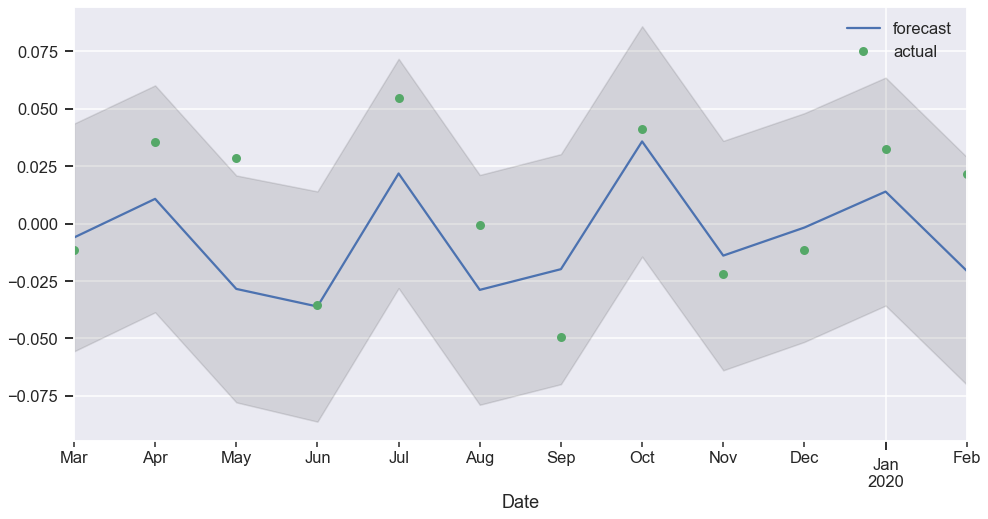

In [10]:
ax = p_seas_gna95_test.plot(label='forecast', y = 'cons_GNA95_seas_adj_pct_change1')
(data_test['cons_GNA95_seas_adj_pct_change1']).plot(label='actual', style='o', ax=ax)
ax.fill_between(p_seas_gna95_test.index, p_seas_gna95_test['lower cons_GNA95_seas_adj_pct_change1'], p_seas_gna95_test['upper cons_GNA95_seas_adj_pct_change1'], color='k', alpha=0.1)
plt.legend()
plt.show()

In [11]:
p1_lst = []
p1_up_ci_lst = []
p1_lo_ci_lst = []
p0 = data_train['cons_GNA95'].iloc[-1]/1e3
p1_last = p0

for idx, row in p_seas_gna95_test.iterrows():
    seas = data_test.loc[idx, 'cons_GNA95_seas_comp']/1e3
    p1 = (row['cons_GNA95_seas_adj_pct_change1'] * p0 + p0) + seas
    p1_up = (row['upper cons_GNA95_seas_adj_pct_change1'] * p1_last + p1_last) + seas
    p1_lo = (row['lower cons_GNA95_seas_adj_pct_change1'] * p1_last + p1_last) + seas
    p0 = data_test.loc[idx, 'cons_GNA95']/1e3
    p1_last = p1
    p1_lst.append(p1)
    p1_up_ci_lst.append(p1_up)
    p1_lo_ci_lst.append(p1_lo)
    

In [12]:
p_seas_gna95_test['p_cons_GNA95'] = np.array(p1_lst)*1e3
p_seas_gna95_test['upper p_cons_GNA95'] = np.array(p1_up_ci_lst)*1e3
p_seas_gna95_test['lower p_cons_GNA95'] = np.array(p1_lo_ci_lst)*1e3

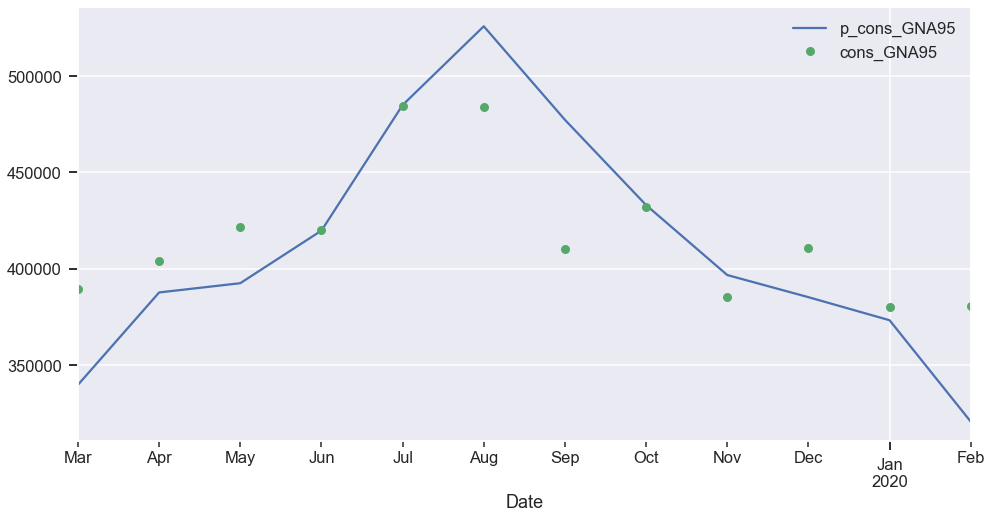

In [13]:
ax = p_seas_gna95_test.plot(y= 'p_cons_GNA95')
data_test.plot(y= 'cons_GNA95', style='o', ax=ax)
plt.show()

## VAR Only

In [14]:
res = VAR(endog=endog_GNA95_train).select_order()
res.summary()

,AIC,BIC,FPE,HQIC
0,-0.4083,-0.3619,0.6648,-0.3895
1,-0.7432,-0.6038,0.4756,-0.6866
2,-0.8457,-0.6134*,0.4293,-0.7514*
3,-0.8634,-0.5382,0.4218,-0.7314
4,-0.8812,-0.4630,0.4145,-0.7114
5,-0.8386,-0.3276,0.4327,-0.6311
6,-0.8470,-0.2431,0.4294,-0.6018
7,-0.8289,-0.1321,0.4377,-0.5459
8,-0.8451,-0.05529,0.4312,-0.5243
9,-0.9174,-0.03466,0.4017,-0.5589


In [15]:
mod_GNA95 = VARMAX(endog_GNA95_train, trend='n', order=(2, 0))
res_GNA95 = mod_GNA95.fit(maxiter=10000)
res_GNA95.summary()

Dep. Variable:,"['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']",No. Observations:,133
Model:,VAR(2),Log Likelihood,-314.530
Date:,"Tue, 30 Jun 2020",AIC,651.060
Time:,23:45:39,BIC,682.854
Sample:,02-01-2008,HQIC,663.980
,- 02-01-2019,,
Covariance Type:,opg,,
Ljung-Box (Q):,"98.40, 72.06",Jarque-Bera (JB):,"5.04, 2.02"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.08, 0.36"
Heteroskedasticity (H):,"0.53, 0.72",Skew:,"-0.21, -0.00"
Prob(H) (two-sided):,"0.04, 0.27",Kurtosis:,"3.85, 3.60"


In [16]:
mod_GNA95 = VARMAX(endog_GNA95_train, trend='n', order=(1, 0))
res_GNA95 = mod_GNA95.fit(maxiter=10000)
res_GNA95.summary()

Dep. Variable:,"['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']",No. Observations:,133
Model:,VAR(1),Log Likelihood,-326.559
Date:,"Tue, 30 Jun 2020",AIC,667.117
Time:,23:45:40,BIC,687.350
Sample:,02-01-2008,HQIC,675.339
,- 02-01-2019,,
Covariance Type:,opg,,
Ljung-Box (Q):,"138.81, 72.52",Jarque-Bera (JB):,"0.66, 1.45"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.72, 0.49"
Heteroskedasticity (H):,"0.58, 0.75",Skew:,"-0.03, -0.02"
Prob(H) (two-sided):,"0.08, 0.35",Kurtosis:,"3.34, 3.51"


## Model Diagnostics

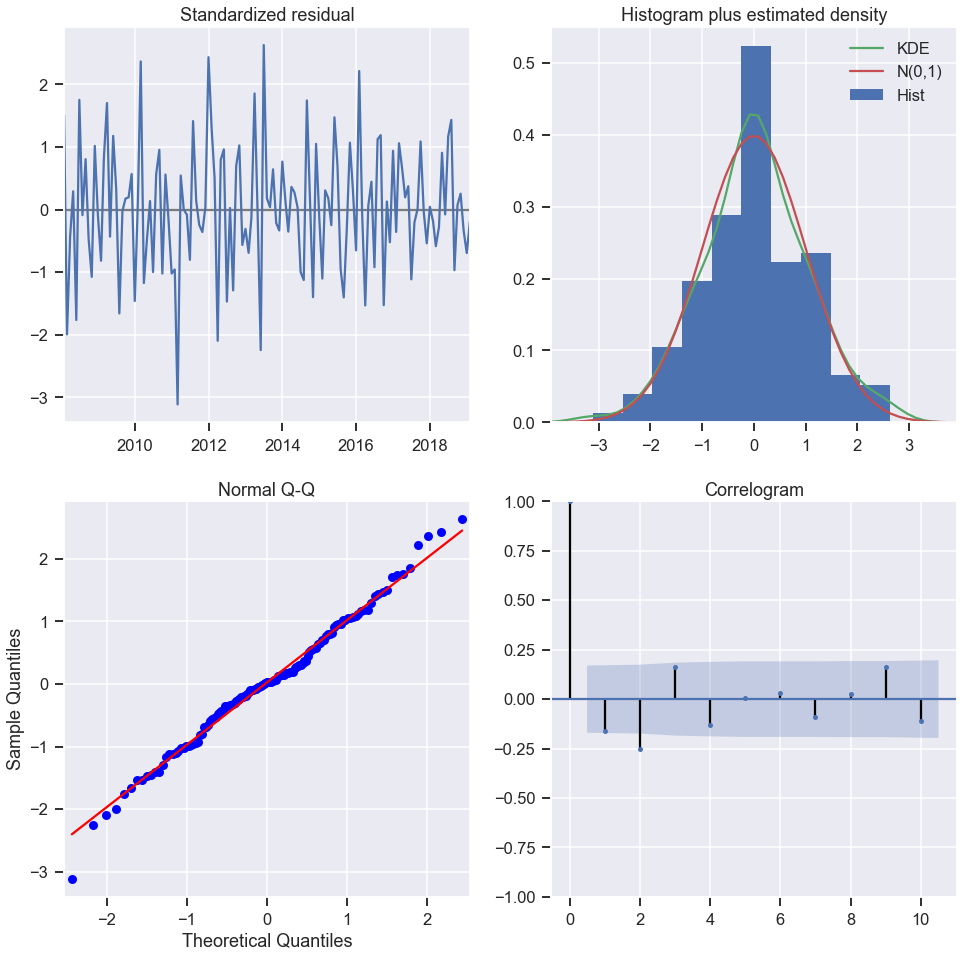

In [17]:
res_GNA95.plot_diagnostics(figsize=(16,16))
plt.show()

## Prediction

In [18]:
p_gna95_train = res_GNA95.predict()[['cons_GNA95_diff1_sdiff12']]
p_gna95_train[['lower cons_GNA95_diff1_sdiff12', 'upper cons_GNA95_diff1_sdiff12']] = res_GNA95.get_prediction().conf_int()[['lower cons_GNA95_diff1_sdiff12', 'upper cons_GNA95_diff1_sdiff12']]

In [19]:
forecast_s = pd.Series(dtype=np.number)
up_ci_s = pd.Series(dtype=np.number)
lo_ci_s = pd.Series(dtype=np.number)

for idx, row in p_gna95_train[13:].iterrows():
    p1 = data.loc[idx - pd.DateOffset(months=1), 'cons_GNA95']/1e3
    p12 = data.loc[idx - pd.DateOffset(months=12), 'cons_GNA95_diff1']/1e3
    forecast = row['cons_GNA95_diff1_sdiff12'] + p1 + p12
    up = row['upper cons_GNA95_diff1_sdiff12'] + p1 + p12
    lo = row['lower cons_GNA95_diff1_sdiff12'] + p1 + p12
    forecast_s[idx] = forecast
    up_ci_s[idx] = up
    lo_ci_s[idx] = lo

In [20]:
p_gna95_train['p_cons_GNA95'] = forecast_s
p_gna95_train['lower p_cons_GNA95'] = up_ci_s
p_gna95_train['upper p_cons_GNA95'] = lo_ci_s
p_gna95_train = p_gna95_train[['p_cons_GNA95', 'lower p_cons_GNA95', 'upper p_cons_GNA95']]*1e3
p_gna95_train['cons_GNA95'] = data_train['cons_GNA95']
p_gna95_train.index = p_gna95_train.index.date
p_gna95_train['model'] = 'var'
p_gna95_train['split'] = 'train'

# Forecast

In [21]:
res_GNA95_upd, p_gna95_test = mle_tsa.endog_forecast(
    train_endog=endog_GNA95_train[['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']],
    test_endog=endog_GNA95_test[['cons_GNA95_diff1_sdiff12', 'price_GNA95_diff1_sdiff12']],
    res=res_GNA95)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


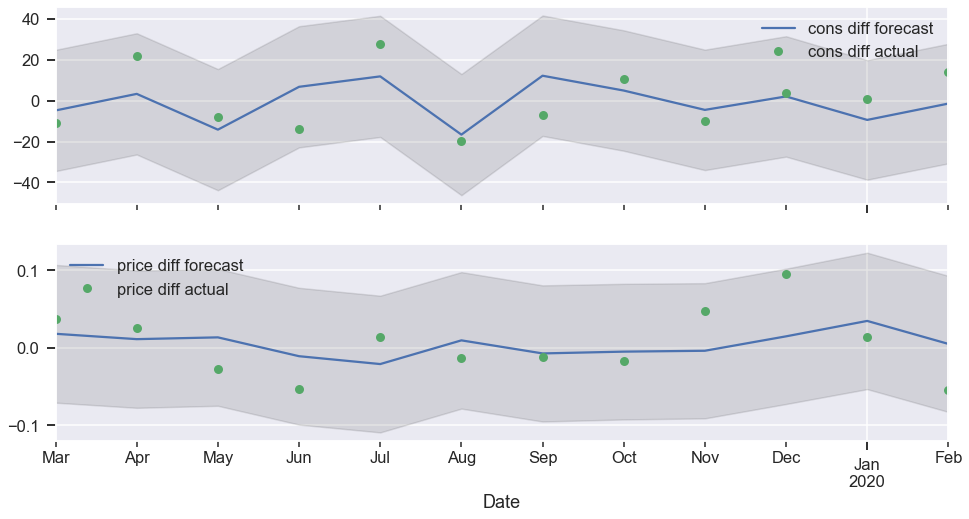

In [22]:
fig, axs = plt.subplots(2,1, sharex=True)

ax=axs[0]
p_gna95_test.plot(y='cons_GNA95_diff1_sdiff12', label='cons diff forecast', ax=ax)
ax.fill_between(p_gna95_test.index, p_gna95_test['lower cons_GNA95_diff1_sdiff12'], p_gna95_test['upper cons_GNA95_diff1_sdiff12'],  color='k', alpha=0.1)
endog_GNA95_test.plot(y='cons_GNA95_diff1_sdiff12', style='o', label='cons diff actual', ax=ax)

ax=axs[1]
p_gna95_test.plot(y='price_GNA95_diff1_sdiff12', label='price diff forecast', ax=ax)
ax.fill_between(p_gna95_test.index, p_gna95_test['lower price_GNA95_diff1_sdiff12'], p_gna95_test['upper price_GNA95_diff1_sdiff12'], color='k', alpha=0.1)
endog_GNA95_test.plot(y='price_GNA95_diff1_sdiff12', label='price diff actual',style='o', ax=ax)
plt.show()

In [23]:
forecast_lst = []
up_ci_lst = []
lo_ci_lst = []

for idx, row in p_gna95_test.iterrows():
    p1 = data.loc[idx - pd.DateOffset(months=1), 'cons_GNA95']/1e3
    p12 = data.loc[idx - pd.DateOffset(months=12), 'cons_GNA95_diff1']/1e3
    forecast = row['cons_GNA95_diff1_sdiff12'] + p1 + p12
    up = row['upper cons_GNA95_diff1_sdiff12'] + p1 + p12
    lo = row['lower cons_GNA95_diff1_sdiff12'] + p1 + p12
    forecast_lst.append(forecast)
    up_ci_lst.append(up)
    lo_ci_lst.append(lo)

In [24]:
p_gna95_test['p_cons_GNA95'] = np.array(forecast_lst)*1e3
p_gna95_test['lower p_cons_GNA95'] = np.array(up_ci_lst)*1e3
p_gna95_test['upper p_cons_GNA95'] = np.array(lo_ci_lst)*1e3

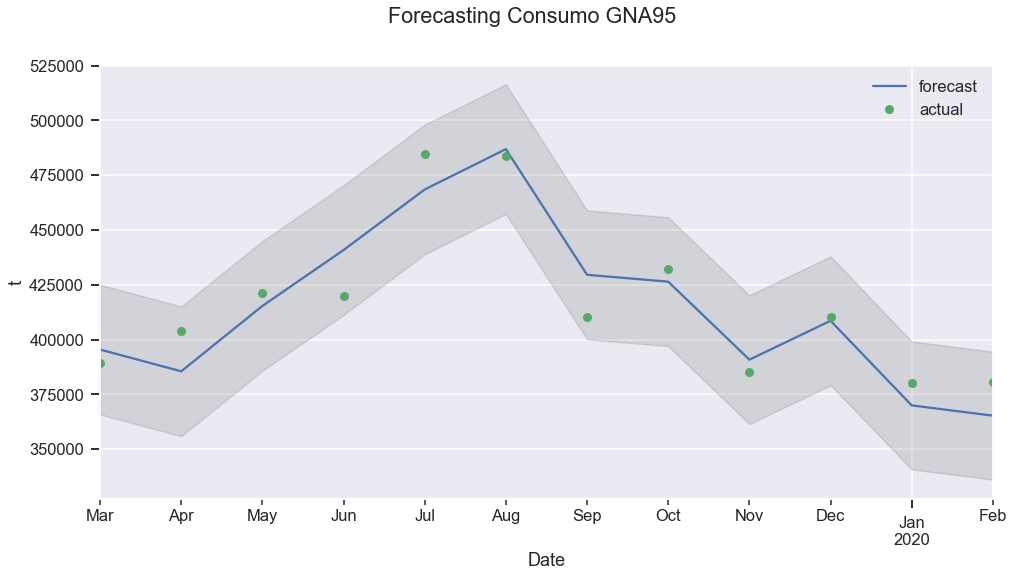

In [25]:
ax = p_gna95_test.plot(y= 'p_cons_GNA95', label='forecast')
data_test.plot(y='cons_GNA95', style='o', label='actual', ax=ax)
ax.fill_between(p_gna95_test.index, p_gna95_test['lower p_cons_GNA95'], p_gna95_test['upper p_cons_GNA95'], color='k', alpha=0.1)
plt.suptitle("Forecasting Consumo GNA95")
plt.ylabel('t')
plt.show()

# Model Assessment

In [26]:
p_gna95_test['model'] = 'var'
p_gna95_test['split'] = 'test'
p_gna95_test.index = p_gna95_test.index.date
p_gna95_test['cons_GNA95'] = data_test['cons_GNA95']

In [27]:
skl_mse(p_seas_gna95_test['cons_GNA95_seas_adj_pct_change1'], endog_seas_GNA95_test['cons_GNA95_seas_adj_pct_change1'])**0.5

0.02736115371832126

In [28]:
skl_mse(p_gna95_test['cons_GNA95_diff1_sdiff12'], endog_GNA95_test['cons_GNA95_diff1_sdiff12'])**0.5

12.56206137380075

In [29]:
mle_tsa.compute_ape(data_test['cons_GNA95'], p_seas_gna95_test['p_cons_GNA95'], ).mean()

0.06317005459970455

In [30]:
mle_tsa.compute_ape( data_test['cons_GNA95'], p_gna95_test['p_cons_GNA95']).mean()

0.02595472219915063

In [31]:
select_cols = ['model', 'split', 'cons_GNA95', 'p_cons_GNA95', 'lower p_cons_GNA95', 'upper p_cons_GNA95']

pd.concat([p_gna95_train, p_gna95_test], axis=0)[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')